In [ ]:
# !pip install huggingface_hub
# !pip install peft==0.14.0

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import Dataset
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    RobertaTokenizer,
    Trainer,
    TrainingArguments,
)

In [3]:
path = "/kaggle/input/text-classification-documentation/df_file.csv"
df = pd.read_csv(path)
df.head

<bound method NDFrame.head of                                                    Text  Label
0     Budget to set scene for election\n \n Gordon B...      0
1     Army chiefs in regiments decision\n \n Militar...      0
2     Howard denies split over ID cards\n \n Michael...      0
3     Observers to monitor UK election\n \n Minister...      0
4     Kilroy names election seat target\n \n Ex-chat...      0
...                                                 ...    ...
2220  India opens skies to competition\n \n India wi...      4
2221  Yukos bankruptcy 'not US matter'\n \n Russian ...      4
2222  Survey confirms property slowdown\n \n Governm...      4
2223  High fuel prices hit BA's profits\n \n British...      4
2224  US trade gap hits record in 2004\n \n The gap ...      4

[2225 rows x 2 columns]>

In [4]:
# Dropping duplicates
df.drop_duplicates(subset=["Text"], inplace=True)

## Split to train, validation and test 

In [5]:
train, temp = train_test_split(df, test_size=0.79, stratify=df["Label"])
valid, temp = train_test_split(temp, test_size=0.9, stratify=temp["Label"])
test, temp = train_test_split(temp, test_size=0.9, stratify=temp["Label"])

print("Train: ", len(train))
print("Validation: ", len(valid))
print("Test: ", len(test))

Train:  446
Validation:  168
Test:  151


In [6]:
label_counts = train["Label"].value_counts(normalize=True) * 100
label_counts

Label
1    23.766816
4    23.542601
0    19.058296
3    17.264574
2    16.367713
Name: proportion, dtype: float64

In [7]:
train = Dataset.from_pandas(train)
valid = Dataset.from_pandas(valid)
test = Dataset.from_pandas(test)

In [ ]:
base_model = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(base_model)

In [9]:
def tokenize(df):
    return tokenizer(df["Text"], padding=True, truncation=True)

In [ ]:
train = train.map(tokenize, batched=True, batch_size=len(train))
valid = valid.map(tokenize, batched=True, batch_size=len(valid))
test = test.map(tokenize, batched=True, batch_size=len(test))

In [11]:
train = train.rename_column("Label", "label")
valid = valid.rename_column("Label", "label")
test = test.rename_column("Label", "label")

train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
valid.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [12]:
class_names = ["Politics", "Sport", "Technology", "Entertainment", "Business"]
id2label = {i: label for i, label in enumerate(class_names)}
id2label

{0: 'Politics', 1: 'Sport', 2: 'Technology', 3: 'Entertainment', 4: 'Business'}

## Training

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    base_model, id2label=id2label
)

peft_config = LoraConfig(
    task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1
)
peft_model = get_peft_model(model, peft_config)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [14]:
peft_model.print_trainable_parameters()

trainable params: 889,349 || all params: 125,538,826 || trainable%: 0.7084


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    learning_rate=0.0001,
    log_level="info",
    report_to="tensorboard",
    logging_dir="./logs",
    logging_steps=10,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=valid,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text, __index_level_0__. If Text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 446
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Training with DataParallel so batch size has been adjusted to: 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 140
  Number of trainable parameters = 889,349
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.605600,1.576759,0.375000,0.276807
2,1.580900,1.538065,0.327381,0.228562
3,1.514200,1.441738,0.636905,0.538480
4,1.390300,1.123029,0.791667,0.763323
5,0.812600,0.615842,0.952381,0.952010
6,0.502500,0.279084,0.976190,0.976199
7,0.297900,0.169195,0.970238,0.970208
8,0.151900,0.128571,0.970238,0.970208
9,0.133600,0.113833,0.970238,0.970208
10,0.103800,0.108610,0.970238,0.970208


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text, __index_level_0__. If Text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 168
  Batch size = 16
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text, __index_level_0__. If Text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 16

TrainOutput(global_step=140, training_loss=0.7939855660711016, metrics={'train_runtime': 216.5614, 'train_samples_per_second': 20.595, 'train_steps_per_second': 0.646, 'total_flos': 1185691992760320.0, 'train_loss': 0.7939855660711016, 'epoch': 10.0})

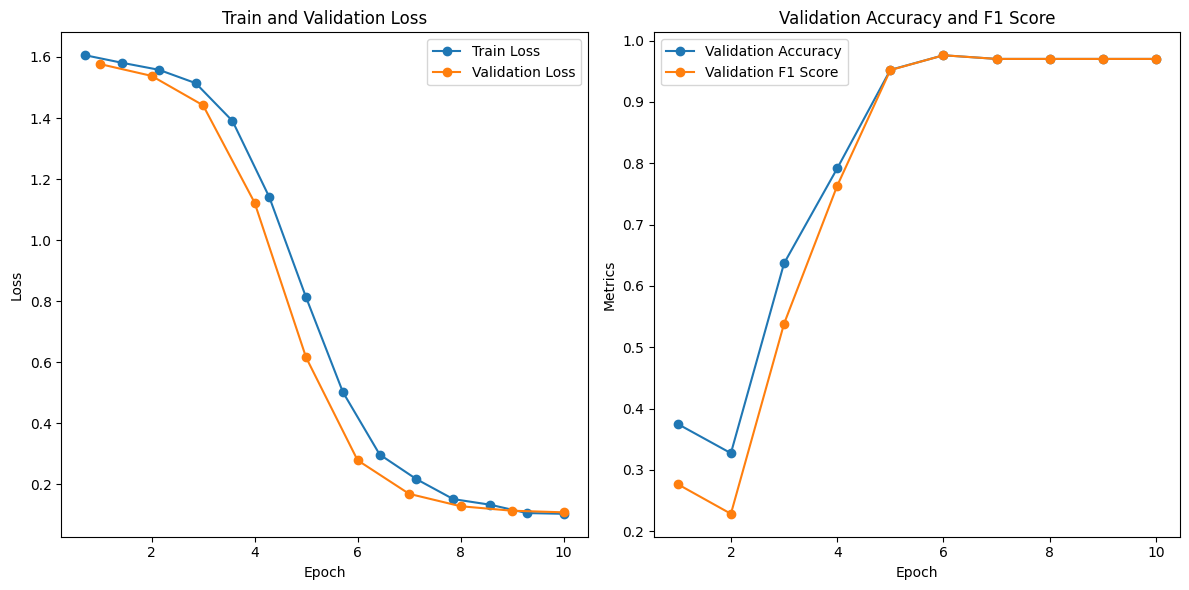

In [18]:
history = trainer.state.log_history

history_df = pd.DataFrame(history)

train_loss = history_df[history_df["loss"].notnull()][["epoch", "loss"]]
eval_loss = history_df[history_df["eval_loss"].notnull()][["epoch", "eval_loss"]]
eval_accuracy = history_df[history_df["eval_accuracy"].notnull()][
    ["epoch", "eval_accuracy"]
]
eval_f1 = history_df[history_df["eval_f1"].notnull()][["epoch", "eval_f1"]]

# plot the losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", marker="o")
plt.plot(
    eval_loss["epoch"], eval_loss["eval_loss"], label="Validation Loss", marker="o"
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# plot the metrics
plt.subplot(1, 2, 2)
plt.plot(
    eval_accuracy["epoch"],
    eval_accuracy["eval_accuracy"],
    label="Validation Accuracy",
    marker="o",
)
plt.plot(eval_f1["epoch"], eval_f1["eval_f1"], label="Validation F1 Score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Validation Accuracy and F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

In [19]:
test_results = trainer.evaluate(test)
print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text, __index_level_0__. If Text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 151
  Batch size = 16
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.9602649006622517
Test F1 Score: 0.9589615529724945


## Save the model

In [20]:
save_directory = "./saved_model"
peft_model.save_pretrained(save_directory)
print(f"Model saved to {save_directory}")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Model saved to ./saved_model
